In [125]:
from pygments.lexers import get_lexer_for_filename
from pygments.lexers import get_lexer_by_name
from pygments.token import Token
from autocorrect import Speller
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import time
from pygments.token import _TokenType
from typing import Union, Tuple
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm

In [126]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("abbreviation_detector")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/wsl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wsl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/wsl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [127]:

statistics = {}
def measure_function_performance(function):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = function(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        if function.__name__ == 'transform_code_into_text':
            file = open(args[0])
            lines = ''.join(file.readlines())
            file.close()
            
            lexer = get_lexer_for_filename(args[0])
            tokens = lexer.get_tokens(lines)
            nbToken = len(list(tokens))
        elif (
            function.__name__ == 'text_similarity_nltk' or 
            function.__name__ == 'text_similarity_scikit'
        ):
            nbToken = len(args[0].split())
        else :
            nbToken = 1
            
        if function.__name__ not in statistics:
            statistics[function.__name__] = []
            
        statistics[function.__name__].append({
            'count_tokens': nbToken,
            'exec_time': execution_time,
        })

        return result

    return wrapper

In [128]:
dossier = 'samples/'
pattern = r'docparse.*\.py'  # Expression régulière pour les fichiers commençant par aaa et se terminant par .py

fichiers_conformes = []

# Parcourir tous les fichiers dans le dossier
for nom_fichier in os.listdir(dossier):
    chemin_fichier = os.path.join(dossier, nom_fichier)
    if os.path.isfile(chemin_fichier) and re.match(pattern, nom_fichier):
        fichiers_conformes.append(nom_fichier)

print("Fichiers conformes au modèle :")
for fichier in fichiers_conformes:
    print(fichier)

Fichiers conformes au modèle :
docparse3.py
docparse9.py
docparse10.py
docparse5.py
docparse2.py
docparse8.py
docparse7.py
docparse6.py
docparse4.py
docparse.py


In [129]:
@measure_function_performance
def replace_acronyms(text: str):
    doc = nlp(text)
    altered_tok = [tok.text for tok in doc]
    for abrv in doc._.abbreviations:
        altered_tok[abrv.start] = str(abrv._.long_form)
    return " ".join(altered_tok)

@measure_function_performance
def split_var_or_function_name(token: Tuple[_TokenType, str]) -> Union[str, bool]:
    """Splits a var or function name into diferent words, e.g.:
        thisIsMyVariable => "this is my variable"
        this_is_my_variable => "this is my variable"
    Args:
        token: Token who can be a variable or function

    Returns:
        str: Element transform in string if a variable or function, return false if the token is not a var or a fonction
    """
    if token[0] == Token.Name.Function or token[0] == Token.Name:
        # use map to add an underscore before each uppercase letter
        modified_string = list(map(lambda x: '_' + x if x.isupper() else x, token[1]))
        # join the modified string and split it at the underscores
        split_string = ''.join(modified_string).split('_')
        # remove any empty strings from the list
        split_string = list(filter(lambda x: x != '', split_string))
        
        return " ".join(split_string)

    return False

@measure_function_performance
def transform_comment_into_text(token: Tuple[_TokenType, str]) -> Union[str, bool]:
    """
    Returns:
        Union[str, bool]: Text of the comment if not a comment return false
    """
    if (
        token[0] == Token.Literal.String.Doc or
        token[0] == Token.Comment.Single or
        token[0] == Token.Comment.Multiline or
        token[0] == Token.Literal.String.Single
    ):
            return token[1]
    
    return False

@measure_function_performance
def transform_code_into_text(filename) -> str:
    # Get source code content
    f = open(filename)
    lines = ''.join(f.readlines())
    f.close()
    text = ""

    # See : https://pygments.org/docs/quickstart/
    #TODO: To be tested with C++ multi comment style, constants, etc.
    #TODO: remove comment mark
    lexer = get_lexer_for_filename(filename)
    tokens = lexer.get_tokens(lines)
    
    for token in tokens:
        comment = transform_comment_into_text(token)
        if comment:
            text += ' ' + comment
            
        splited_element = split_var_or_function_name(token)
        if splited_element:
            text += ' ' + splited_element

    # # Remove duplicate spaces and new lines
    text = " ".join(text.split())

    # #Expand acronyms
    text = replace_acronyms(text)

    # #Auto correct
    spell = Speller()
    text = spell(text)
    return text


In [130]:
@measure_function_performance
def text_similarity_nltk(text1, text2):
    # Tokenize and lemmatize the texts
    tokens1 = word_tokenize(text1)
    tokens2 = word_tokenize(text2)
    lemmatizer = WordNetLemmatizer()
    tokens1 = [lemmatizer.lemmatize(token) for token in tokens1]
    tokens2 = [lemmatizer.lemmatize(token) for token in tokens2]

    # Remove stopwords
    stop_words = stopwords.words('english')
    tokens1 = [token for token in tokens1 if token not in stop_words]
    tokens2 = [token for token in tokens2 if token not in stop_words]
    
    tokens1 = [token for token in tokens1 if token not in ['``', '#']]
    tokens2 = [token for token in tokens2 if token not in ['``', '#']]
    # Create the TF-IDF vectors
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([' '.join(tokens1), ' '.join(tokens2)])

    # Calculate the cosine similarity
    similarity = cosine_similarity(vectors)
    return similarity

@measure_function_performance
def text_similarity_scikit(text1, text2):
    # Convert the texts into TF-IDF vectors
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([text1, text2])

    # Calculate the cosine similarity between the vectors
    similarity = cosine_similarity(vectors)
    return similarity

In [131]:
base = "Make it possible to customize the dict that cuntains the list of words that suggest we have a spam."
for fichier in fichiers_conformes:
    text = transform_code_into_text(dossier + fichier)
    text_similarity_scikit(text, base)
    text_similarity_nltk(text, base)
    

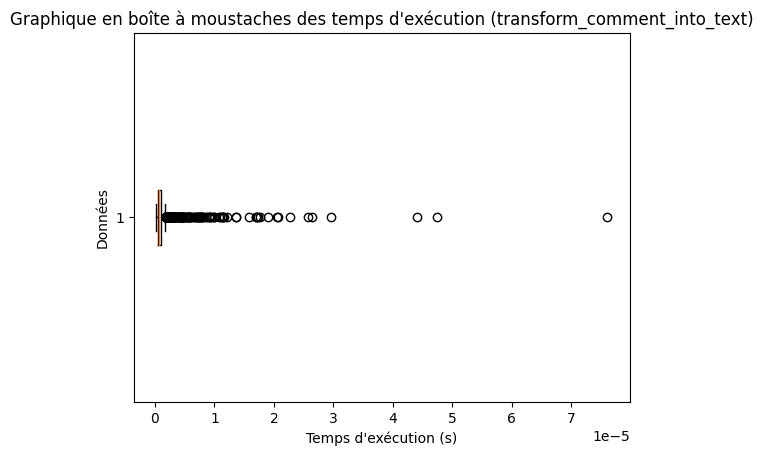

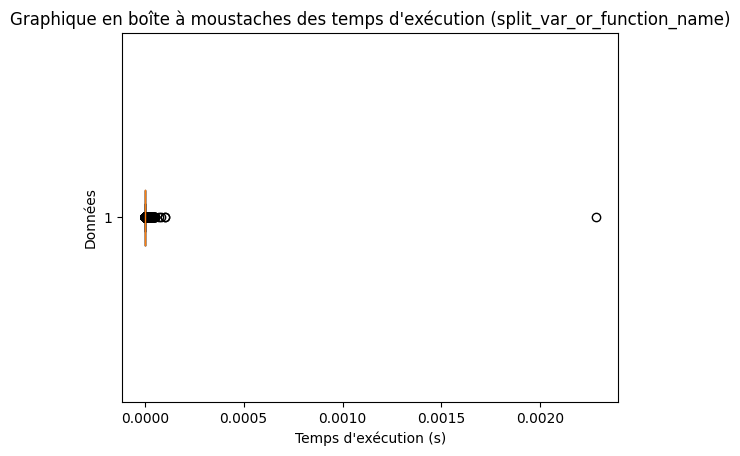

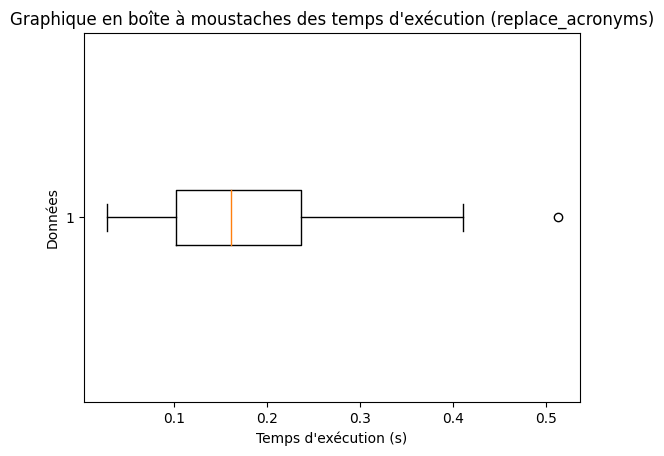

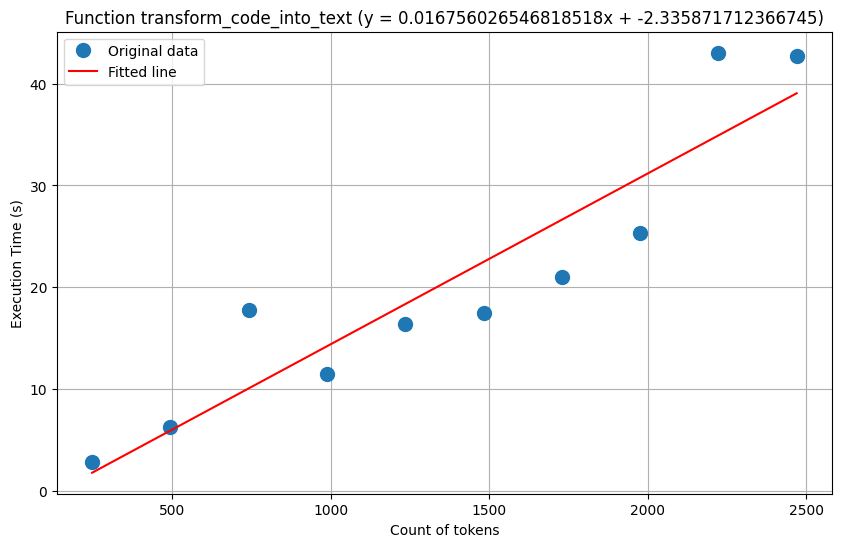

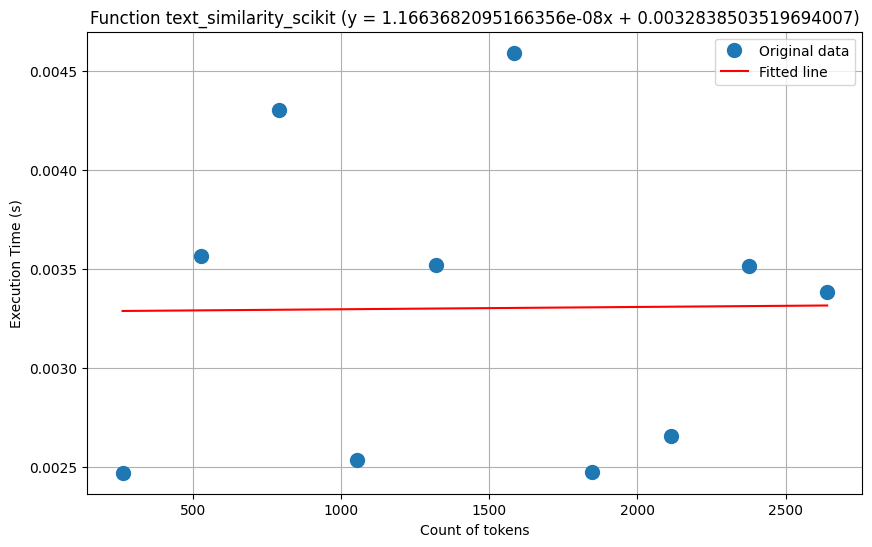

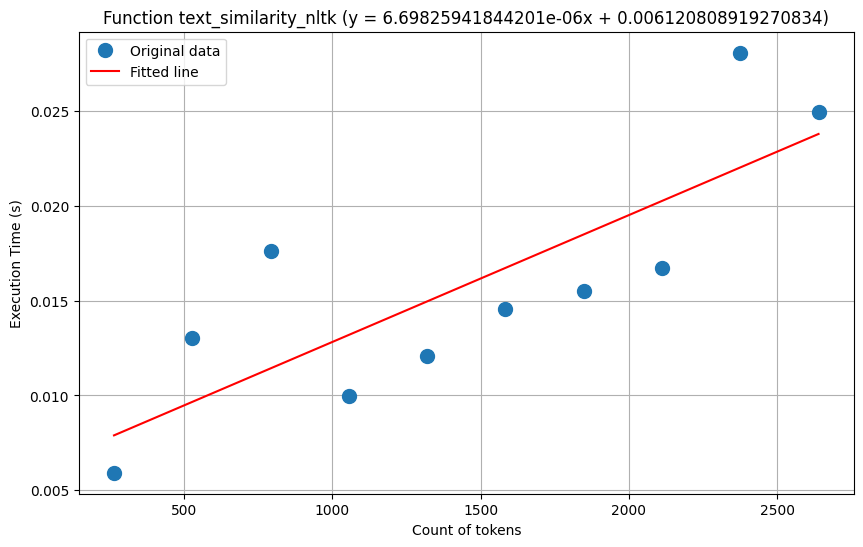

In [132]:
for statistic in statistics: 
    if (
        statistic == 'transform_code_into_text' or 
        statistic == 'text_similarity_nltk' or 
        statistic == 'text_similarity_scikit'
    ):
        # Tri des données en fonction de count_tokens de manière croissante
        sorted_data = sorted(statistics[statistic], key=lambda x: x['count_tokens'])

        count_tokens = [entry['count_tokens'] for entry in sorted_data]
        exec_time = [entry['exec_time'] for entry in sorted_data]

        plt.figure(figsize=(10, 6))

        A = np.vstack([count_tokens, np.ones(len(count_tokens))]).T
        m, c = np.linalg.lstsq(A, exec_time, rcond=None)[0]

        # Calcul des valeurs prédites
        # y_pred = np.polyval(coeffs, count_tokens)

        plt.plot(count_tokens, exec_time, 'o', label='Original data', markersize=10)
        plt.plot(count_tokens, m*np.array(count_tokens) + c, 'r', label='Fitted line')
        plt.legend()
        # plt.plot(count_tokens, y_pred, color='red', label='Tendance')

        # plt.plot(count_tokens, exec_time, marker='o', color='blue')
        plt.xlabel('Count of tokens')
        plt.ylabel('Execution Time (s)')
        plt.title(f'Function {statistic} (y = {m}x + {c})')
        plt.grid(True)

        plt.show()
    else :
        exec_times = [entry['exec_time'] for entry in statistics[statistic]]

        # Créer le graphique en boîte à moustaches
        plt.boxplot(exec_times, vert=False)
        plt.xlabel('Temps d\'exécution (s)')
        plt.ylabel('Données')
        plt.title('Graphique en boîte à moustaches des temps d\'exécution ('+ statistic +')')
        plt.show()

In [133]:
results = []
for filename in os.listdir('samples/'):
    if os.path.isfile(os.path.join('samples/', filename)):
        transform_file = transform_code_into_text('./samples/' + filename)
        results.append({
            'file': filename,
            'distance': text_similarity_scikit(transform_file, base)[0][1],
        })
        
sorted_data = sorted(results, key=lambda x: x['distance'], reverse=True)

# Impression formatée des données
print("Organisé par ordre décroissant sur la distance:")
print("=" * 45)
for entry in sorted_data:
    print(f"File: {entry['file']:<20} Distance: {entry['distance']:.6f}")
print("=" * 45)

/home/wsl/legacy-impact/jupyterenv/lib/python3.8/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Organisé par ordre décroissant sur la distance:
File: tetris.py            Distance: 0.262743
File: BlogController.php   Distance: 0.255935
File: gtest-printers.cc    Distance: 0.192463
File: SplFileInfo.php      Distance: 0.182340
File: docparse3.py         Distance: 0.103827
File: docparse9.py         Distance: 0.103827
File: docparse10.py        Distance: 0.103827
File: docparse5.py         Distance: 0.103827
File: docparse2.py         Distance: 0.103827
File: docparse8.py         Distance: 0.103827
File: docparse7.py         Distance: 0.103827
File: docparse6.py         Distance: 0.103827
File: docparse4.py         Distance: 0.103827
File: docparse.py          Distance: 0.103827
File: transform.py         Distance: 0.077029
File: Snake Game.py        Distance: 0.031894
File: entry_with_update.py Distance: 0.000000


In [135]:
results = []
for filename in os.listdir('samples/'):
    if os.path.isfile(os.path.join('samples/', filename)):
        transform_file = transform_code_into_text('./samples/' + filename)
        results.append({
            'file': filename,
            'distance': text_similarity_nltk(transform_file, base)[0][1],
        })
        
sorted_data = sorted(results, key=lambda x: x['distance'], reverse=True)

# Impression formatée des données
print("Organisé par ordre décroissant sur la distance:")
print("=" * 45)
for entry in sorted_data:
    print(f"File: {entry['file']:<20} Distance: {entry['distance']:.6f}")
print("=" * 45)

Organisé par ordre décroissant sur la distance:
File: transform.py         Distance: 0.032482
File: tetris.py            Distance: 0.021550
File: docparse10.py        Distance: 0.011146
File: docparse5.py         Distance: 0.011146
File: docparse2.py         Distance: 0.011146
File: docparse8.py         Distance: 0.011146
File: docparse4.py         Distance: 0.011146
File: docparse.py          Distance: 0.011146
File: docparse3.py         Distance: 0.011146
File: docparse9.py         Distance: 0.011146
File: docparse6.py         Distance: 0.011146
File: docparse7.py         Distance: 0.011146
File: gtest-printers.cc    Distance: 0.004428
File: Snake Game.py        Distance: 0.000000
File: BlogController.php   Distance: 0.000000
File: entry_with_update.py Distance: 0.000000
File: SplFileInfo.php      Distance: 0.000000
